In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

<script type="text/javascript">window.PlotlyConfig = {MathJaxConfig: 'local'};</script><script type="text/javascript">if (window.MathJax) {MathJax.Hub.Config({SVG: {font: "STIX-Web"}});}</script><script>requirejs.config({paths: { 'plotly': ['https://cdn.plot.ly/plotly-latest.min']},});if(!window._Plotly) {require(['plotly'],function(plotly) {window._Plotly=plotly;});}</script>

In [2]:
train = pd.read_csv('./jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('./jinnan_round1_testA_20181227.csv', encoding = 'gb18030')

In [3]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,96.991404,96.991404,float64
7,A7,75,89.326648,89.326648,object
8,A8,8,89.326648,89.326648,float64
39,B11,37,60.816619,60.816619,object
38,B10,180,17.478510,17.478510,object
3,A3,3,3.008596,95.702006,float64
29,B1,21,0.716332,53.796562,float64
23,A23,3,0.214900,99.641834,float64
21,A21,12,0.214900,89.828080,float64
30,B2,3,0.143266,98.424069,float64


In [4]:
stats = []
for col in test.columns:
    stats.append((col, test[col].nunique(), test[col].isnull().sum() * 100 / test.shape[0], test[col].value_counts(normalize=True, dropna=False).values[0] * 100, test[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,98.000000,98.000000,float64
7,A7,15,88.000000,88.000000,object
8,A8,2,88.000000,88.000000,float64
39,B11,11,59.333333,59.333333,object
38,B10,50,14.666667,14.666667,object
3,A3,2,2.000000,97.333333,float64
25,A25,7,0.666667,42.000000,float64
27,A27,11,0.666667,47.333333,float64
20,A20,52,0.666667,20.000000,object
29,B1,13,0.666667,56.000000,float64


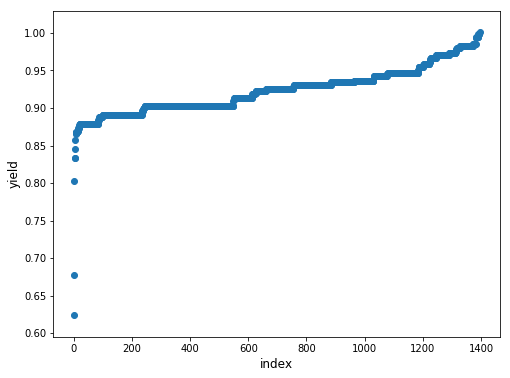

In [5]:
target_col = "收率"

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

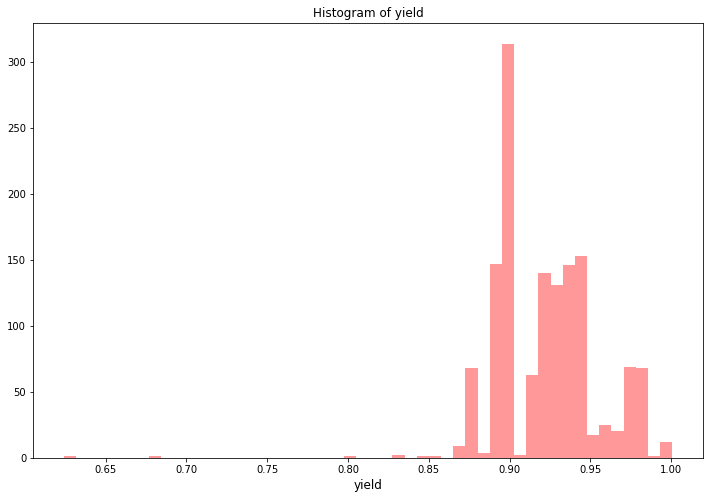

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(train[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [7]:
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

In [8]:
# 删除某一类别占比超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(col,rate)

# 删除异常值
train = train[train['收率']>0.87]
        
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

A1 0.9863896848137536
A2 0.9699140401146131
A3 0.9570200573065902
A4 0.9570200573065902
B2 0.9842406876790831


In [9]:
# 合并数据集
target = train['收率']
del train['收率']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)

In [10]:
def timeTranSecond(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600
    
    return tm
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    try:
        data[f] = data[f].apply(timeTranSecond)
    except:
        print(f,'应该在前面被删除了！')

def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1 
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data.apply(lambda df: getDuration(df[f]), axis=1)

In [11]:
data['样本id'] = data['样本id'].apply(lambda x: int(x.split('_')[1]))

categorical_columns = [f for f in data.columns if f not in ['样本id']]
numerical_columns = [f for f in data.columns if f not in categorical_columns]

In [12]:
numerical_columns

['样本id']

In [13]:
#label encoder
for f in categorical_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]
print(train.shape)
print(test.shape)

(1381, 33)
(150, 33)


In [14]:
test.columns
data[f].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

In [15]:
train['B14']

0       0
1       0
2       0
3       0
4       1
5       1
6       0
7       0
8       1
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      1
17      0
18      0
19      0
20      2
21      2
22      2
23      1
24      1
25      1
26      2
27      1
28      3
29      0
       ..
1351    0
1352    0
1353    0
1354    1
1355    6
1356    0
1357    0
1358    0
1359    2
1360    0
1361    0
1362    0
1363    0
1364    0
1365    0
1366    1
1367    0
1368    0
1369    1
1370    5
1371    1
1372    0
1373    2
1374    0
1375    5
1376    2
1377    1
1378    0
1379    0
1380    0
Name: B14, Length: 1381, dtype: int64

In [16]:
#train['target'] = list(target) 
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_columns = []
for f1 in categorical_columns:
    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if cate_rate < 0.90:
        for f2 in li:
            col_name = 'B14_to_'+f1+"_"+f2+'_mean'
            mean_columns.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            train[col_name] = train['B14'].map(order_label)
            miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
            if miss_rate > 0:
                train = train.drop([col_name], axis=1)
                mean_columns.remove(col_name)
            else:
                test[col_name] = test['B14'].map(order_label)
                
train.drop(li+['target'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

(1381, 108)
(150, 108)


In [17]:
miss_rate

0.0

In [18]:
X_train = train[mean_columns+numerical_columns].values
X_test = test[mean_columns+numerical_columns].values
# one hot
enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_train.shape)
print(X_test.shape)

(1381, 1245)
(150, 1245)


In [19]:
y_train = target.values

In [20]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000199467	valid_1's l2: 0.000225194


[400]	training's l2: 0.00013277	valid_1's l2: 0.000156311


[600]	training's l2: 0.000112743	valid_1's l2: 0.000137571


[800]	training's l2: 0.000104098	valid_1's l2: 0.000130296


[1000]	training's l2: 9.92792e-05	valid_1's l2: 0.000126587


[1200]	training's l2: 9.61078e-05	valid_1's l2: 0.000124377


[1400]	training's l2: 9.38058e-05	valid_1's l2: 0.000123126


[1600]	training's l2: 9.18174e-05	valid_1's l2: 0.000121903


[1800]	training's l2: 9.02953e-05	valid_1's l2: 0.000121085


[2000]	training's l2: 8.88748e-05	valid_1's l2: 0.00012038


[2200]	training's l2: 8.77928e-05	valid_1's l2: 0.000120072


[2400]	training's l2: 8.67909e-05	valid_1's l2: 0.000119569


[2600]	training's l2: 8.58795e-05	valid_1's l2: 0.00011937


[2800]	training's l2: 8.50688e-05	valid_1's l2: 0.000118968
Early stopping, best iteration is:
[2796]	training's l2: 8.50688e-05	valid_1's l2: 0.000118968


fold n°2
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000197364	valid_1's l2: 0.000215793


[400]	training's l2: 0.000128731	valid_1's l2: 0.00016299


[600]	training's l2: 0.000109853	valid_1's l2: 0.000150086


[800]	training's l2: 0.000101277	valid_1's l2: 0.000145381


[1000]	training's l2: 9.60102e-05	valid_1's l2: 0.000142582


[1200]	training's l2: 9.25855e-05	valid_1's l2: 0.000140973


[1400]	training's l2: 9.02109e-05	valid_1's l2: 0.000139844


[1600]	training's l2: 8.8345e-05	valid_1's l2: 0.000139081


[1800]	training's l2: 8.6705e-05	valid_1's l2: 0.000138579


[2000]	training's l2: 8.53792e-05	valid_1's l2: 0.000138045


[2200]	training's l2: 8.42102e-05	valid_1's l2: 0.000137679
[2400]	training's l2: 8.35341e-05	valid_1's l2: 0.000137397
Early stopping, best iteration is:
[2327]	training's l2: 8.35459e-05	valid_1's l2: 0.000137385

fold n°3
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000199228	valid_1's l2: 0.000269781


[400]	training's l2: 0.000131424	valid_1's l2: 0.000189334


[600]	training's l2: 0.000110253	valid_1's l2: 0.000165659


[800]	training's l2: 0.000101462	valid_1's l2: 0.000156199


[1000]	training's l2: 9.63294e-05	valid_1's l2: 0.000151602


[1200]	training's l2: 9.27961e-05	valid_1's l2: 0.0001485


[1400]	training's l2: 9.02684e-05	valid_1's l2: 0.000146619


[1600]	training's l2: 8.83341e-05	valid_1's l2: 0.000145061


[1800]	training's l2: 8.67734e-05	valid_1's l2: 0.000143813


[2000]	training's l2: 8.55185e-05	valid_1's l2: 0.000142899
Early stopping, best iteration is:
[2030]	training's l2: 8.53306e-05	valid_1's l2: 0.000142772


fold n°4
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000203263	valid_1's l2: 0.000215135


[400]	training's l2: 0.000133862	valid_1's l2: 0.000159616


[600]	training's l2: 0.000115121	valid_1's l2: 0.000143837


[800]	training's l2: 0.0001065	valid_1's l2: 0.000136875
[1000]	training's l2: 0.000101204	valid_1's l2: 0.000133268


[1200]	training's l2: 9.74472e-05	valid_1's l2: 0.000131358
[1400]	training's l2: 9.44397e-05	valid_1's l2: 0.000129757


[1600]	training's l2: 9.20834e-05	valid_1's l2: 0.000128849


[1800]	training's l2: 9.03011e-05	valid_1's l2: 0.000128071
[2000]	training's l2: 8.88582e-05	valid_1's l2: 0.000127579


[2200]	training's l2: 8.76116e-05	valid_1's l2: 0.000127106
[2400]	training's l2: 8.64523e-05	valid_1's l2: 0.00012667
Early stopping, best iteration is:
[2440]	training's l2: 8.6242e-05	valid_1's l2: 0.00012663

fold n°5
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000205232	valid_1's l2: 0.000204739

[400]	training's l2: 0.00013645	valid_1's l2: 0.000136152
[600]	training's l2: 0.000117051	valid_1's l2: 0.000118821


[800]	training's l2: 0.000107679	valid_1's l2: 0.000112301


[1000]	training's l2: 0.000102275	valid_1's l2: 0.000109004


[1200]	training's l2: 9.86156e-05	valid_1's l2: 0.000106866
[1400]	training's l2: 9.55963e-05	valid_1's l2: 0.000105399


[1600]	training's l2: 9.33219e-05	valid_1's l2: 0.000104455
[1800]	training's l2: 9.15222e-05	valid_1's l2: 0.000103684


[2000]	training's l2: 8.9983e-05	valid_1's l2: 0.000103136
[2200]	training's l2: 8.86705e-05	valid_1's l2: 0.000102565


[2400]	training's l2: 8.76145e-05	valid_1's l2: 0.000102237
Early stopping, best iteration is:
[2383]	training's l2: 8.76308e-05	valid_1's l2: 0.000102221


CV score: 0.00012559


In [21]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1


[0]	train-rmse:0.422932	valid_data-rmse:0.423819


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256998	valid_data-rmse:0.257735


[200]	train-rmse:0.156612	valid_data-rmse:0.157346


[300]	train-rmse:0.095898	valid_data-rmse:0.09673


[400]	train-rmse:0.059299	valid_data-rmse:0.060139


[500]	train-rmse:0.037282	valid_data-rmse:0.038227


[600]	train-rmse:0.024083	valid_data-rmse:0.025341


[700]	train-rmse:0.016246	valid_data-rmse:0.018075


[800]	train-rmse:0.011676	valid_data-rmse:0.014289


[900]	train-rmse:0.009085	valid_data-rmse:0.012478


[1000]	train-rmse:0.00764	valid_data-rmse:0.011644


[1100]	train-rmse:0.006807	valid_data-rmse:0.011277


[1200]	train-rmse:0.006302	valid_data-rmse:0.011118


[1300]	train-rmse:0.005924	valid_data-rmse:0.01103


[1400]	train-rmse:0.005645	valid_data-rmse:0.010989


[1500]	train-rmse:0.005373	valid_data-rmse:0.01096


[1600]	train-rmse:0.005156	valid_data-rmse:0.010947


[1700]	train-rmse:0.00494	valid_data-rmse:0.010928


[1800]	train-rmse:0.004749	valid_data-rmse:0.010918


[1900]	train-rmse:0.004576	valid_data-rmse:0.010919


[2000]	train-rmse:0.004414	valid_data-rmse:0.010913


[2100]	train-rmse:0.004241	valid_data-rmse:0.010912


[2200]	train-rmse:0.004096	valid_data-rmse:0.010917


Stopping. Best iteration:
[2029]	train-rmse:0.004357	valid_data-rmse:0.010911



fold n°2
[0]	train-rmse:0.424042	valid_data-rmse:0.419362


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.25767	valid_data-rmse:0.254152


[200]	train-rmse:0.157039	valid_data-rmse:0.154291


[300]	train-rmse:0.096141	valid_data-rmse:0.093798


[400]	train-rmse:0.05944	valid_data-rmse:0.057642


[500]	train-rmse:0.037318	valid_data-rmse:0.036215


[600]	train-rmse:0.024037	valid_data-rmse:0.023806


[700]	train-rmse:0.01615	valid_data-rmse:0.016988


[800]	train-rmse:0.01152	valid_data-rmse:0.013574


[900]	train-rmse:0.008903	valid_data-rmse:0.012086


[1000]	train-rmse:0.007425	valid_data-rmse:0.011505


[1100]	train-rmse:0.00659	valid_data-rmse:0.011301


[1200]	train-rmse:0.006085	valid_data-rmse:0.01125


[1300]	train-rmse:0.005721	valid_data-rmse:0.011256


[1400]	train-rmse:0.005404	valid_data-rmse:0.011282


Stopping. Best iteration:
[1219]	train-rmse:0.006004	valid_data-rmse:0.011246



fold n°3
[0]	train-rmse:0.422401	valid_data-rmse:0.425951


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256655	valid_data-rmse:0.259777


[200]	train-rmse:0.156366	valid_data-rmse:0.159184


[300]	train-rmse:0.09575	valid_data-rmse:0.098395


[400]	train-rmse:0.059241	valid_data-rmse:0.061545


[500]	train-rmse:0.037259	valid_data-rmse:0.039185


[600]	train-rmse:0.024029	valid_data-rmse:0.0259


[700]	train-rmse:0.016155	valid_data-rmse:0.018438


[800]	train-rmse:0.011524	valid_data-rmse:0.014515


[900]	train-rmse:0.0089	valid_data-rmse:0.012718


[1000]	train-rmse:0.007412	valid_data-rmse:0.011959


[1100]	train-rmse:0.006538	valid_data-rmse:0.011664


[1200]	train-rmse:0.00603	valid_data-rmse:0.01156


[1300]	train-rmse:0.005691	valid_data-rmse:0.011538


[1400]	train-rmse:0.005402	valid_data-rmse:0.011535


[1500]	train-rmse:0.005147	valid_data-rmse:0.011547


Stopping. Best iteration:
[1368]	train-rmse:0.005495	valid_data-rmse:0.011532



fold n°4


[0]	train-rmse:0.422949	valid_data-rmse:0.423757


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257035	valid_data-rmse:0.256922


[200]	train-rmse:0.156648	valid_data-rmse:0.156018


[300]	train-rmse:0.095932	valid_data-rmse:0.095259


[400]	train-rmse:0.059328	valid_data-rmse:0.058738


[500]	train-rmse:0.037297	valid_data-rmse:0.036922


[600]	train-rmse:0.024077	valid_data-rmse:0.024185


[700]	train-rmse:0.016225	valid_data-rmse:0.017195


[800]	train-rmse:0.011636	valid_data-rmse:0.013696


[900]	train-rmse:0.009009	valid_data-rmse:0.012087


[1000]	train-rmse:0.007538	valid_data-rmse:0.011441


[1100]	train-rmse:0.006687	valid_data-rmse:0.011193


[1200]	train-rmse:0.006168	valid_data-rmse:0.011094


[1300]	train-rmse:0.005798	valid_data-rmse:0.011059


[1400]	train-rmse:0.005504	valid_data-rmse:0.011049


[1500]	train-rmse:0.005248	valid_data-rmse:0.011052


[1600]	train-rmse:0.005016	valid_data-rmse:0.011053


Stopping. Best iteration:
[1401]	train-rmse:0.005502	valid_data-rmse:0.011048



fold n°5
[0]	train-rmse:0.423228	valid_data-rmse:0.422635


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257179	valid_data-rmse:0.256869


[200]	train-rmse:0.156733	valid_data-rmse:0.156544


[300]	train-rmse:0.096029	valid_data-rmse:0.095783


[400]	train-rmse:0.059445	valid_data-rmse:0.05925


[500]	train-rmse:0.037422	valid_data-rmse:0.037489


[600]	train-rmse:0.024212	valid_data-rmse:0.024657


[700]	train-rmse:0.016361	valid_data-rmse:0.01737


[800]	train-rmse:0.011784	valid_data-rmse:0.013533


[900]	train-rmse:0.009146	valid_data-rmse:0.011671


[1000]	train-rmse:0.007681	valid_data-rmse:0.010826


[1100]	train-rmse:0.006848	valid_data-rmse:0.010463


[1200]	train-rmse:0.006328	valid_data-rmse:0.010301


[1300]	train-rmse:0.005941	valid_data-rmse:0.01023


[1400]	train-rmse:0.005643	valid_data-rmse:0.010205


[1500]	train-rmse:0.005394	valid_data-rmse:0.010204


[1600]	train-rmse:0.005151	valid_data-rmse:0.010193


[1700]	train-rmse:0.004931	valid_data-rmse:0.010201


Stopping. Best iteration:
[1564]	train-rmse:0.005237	valid_data-rmse:0.01019



CV score: 0.00012089


In [22]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_squared_error(target.values, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.00011710424554469147

In [23]:
sub_df = pd.read_csv('./jinnan_round1_submit_20181227.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
pd